In [1]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib

import matplotlib.pyplot as plt
from load_plot_model import load_dtm, plot_model, plot_hist
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/earth-analytics/data/watershed-project is now the working directory


In [3]:
# DTM urls
hwy_93_dtm_url = ('https://github.com/lechipman/watershed-project/'
                  'releases/download/v1.0.0/hwy_93_DTM_2.tif')
av_dtm_url = ('https://github.com/lechipman/watershed-project'
                        '/releases/download/v1.0.0/AV_DEM_2.tif')
hm_dtm_url = ('https://github.com/lechipman/watershed-project'
                        '/releases/download/v1.0.0/HM_DTM_2.tif')

In [13]:
# Load dataarrays for dtms
hwy_93_dtm = load_dtm(data_url = hwy_93_dtm_url, 
                          site_name = 'uav_h93',
                          file_name = 'dtm_highway93.tif')
av_dtm = load_dtm(data_url = av_dtm_url, 
                          site_name = 'uav_av',
                          file_name = 'dtm_apple_valley.tif')
hm_dtm = load_dtm(data_url = hm_dtm_url, 
                          site_name = 'uav_hm',
                          file_name = 'dtm_hall_meadows.tif')

uav_hm does not exist. Creating...
uav_hm/dtm_hall_meadows.tif does not exist. Downloading...


In [34]:
# redo plot model function to loop through dtms/ax and plot each on new ax
# Function to plot multiple elevation models
def plot_models(model, title, coarsen, ax):
    """
    Creates plots of multiple DTMs or REMs.
    
    Parameters
    ------------
    #row, col: int
     #   The number of rows and columns in figure.
        
    model: dataarray
        The dataarray to plot.

    title: str
        The title of the plot.
        
    coarsen: boolean
        True = coarsen data, False = do not coarsen.
    
    ax: axes
        A matplotlib axes object.

    Returns
    -------
    A plot of the elevation model with specified title.
    """

    # Hide x and y axes labels and ticks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # If DTM, coarsen
    if coarsen == True:
        model.coarsen(
            x=3,
            boundary='trim').mean().coarsen(
                y=3,
                boundary='trim').mean().squeeze()
    # Plot DTM
    model.plot(ax=ax)

    # Add title
    ax.set_title(title, fontsize=14)
    
    ax.legend('off')
    ax.axis('off')

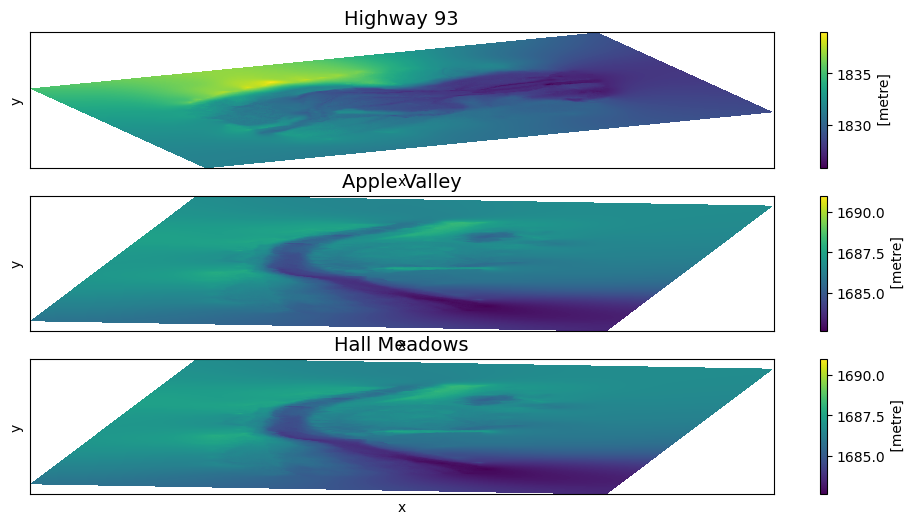

In [6]:
# Define plot space with x subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 6))

# List of fire names to pass to function
site_name = ('Highway 93', 'Apple Valley', 'Hall Meadows')

# List of dtms to pass to function
dtm_list = (hwy_93_dtm, av_dtm, hm_dtm)

# List of lidar dtms to pass to function
#lidar_dtm_list = (hwy_93_dtm, av_dtm, hm_dtm)

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=dtm_list[i],
        title=site_name[i],
        coarsen=(True, True, True),
        ax=axe)

In [7]:
#plot_model(model = av_dtm, title='Apple Valley DTM', coarsen=True)

In [14]:
# Set paths to lidar data
lidar_dir = 'lidar_data'
lidar_hwy93_path = os.path.join(
    lidar_dir, 
    'lidar_hw93', 
    '3075_1760', 
    '3075_1760_elev.asc')

lidar_av_path = os.path.join(
    lidar_dir, 
    'lidar_av', 
    '3055_1875', 
    '3055_1875_elev.asc')

lidar_hm_path = os.path.join(
    lidar_dir, 
    'lidar_hm', 
    '3060_1865', 
    '3060_1865_elev.asc')

lidar_paths = (lidar_hwy93_path, lidar_av_path, lidar_hm_path)
site_names = ('highway93', 'applevalley', 'hallmeadows')

In [17]:
# Function to load lidar, reproject, and clip
def process_lidar(uav_dtm, lidar_path, name):
    
    """
    Loads the lidar DTM, reporjects, and clips to UAV DTM boundary.
    
    Parameters
    ------------   
    dtm_name: dataarray
        The dtm to clip and reproject to.

    lidar_path: str
        Path to LiDAR.
        
    Returns
    -------
    lidar_dtm: dataarray.
        The processed lidar dtm.
    """
    
    # CRS of UAV DTM 
    uav_dtm_crs = uav_dtm.rio.crs
    
    # Find boundaries of uav_dtm
    xmin, ymin, xmax, ymax = (float(uav_dtm.x.min()), 
                          float(uav_dtm.y.min()), 
                          float(uav_dtm.x.max()), 
                          float(uav_dtm.y.max()))
    
    # Create dataarray for lidar DTM
    lidar_dtm = rxr.open_rasterio(lidar_path, masked=True)
    
    # Change CRS of lidar_dtm (2876) to uav_dtm_crs (4326)
    lidar_dtm_crs = lidar_dtm.rio.reproject(uav_dtm_crs)
    lidar_dtm_crs.rio.crs
    
    # Clip lidar dtm to UAV dtm
    lidar_clipped_dtm = (lidar_dtm_crs
                         .rio
                         .clip_box(xmin, ymin, xmax, ymax))
    
    # Save the clipped lidar dtm as raster for use in RiverREM
    #lidar_clipped_dtm.rio.to_raster("LiDAR_DTM_{}.tif").format(name)
    lidar_clipped_dtm.rio.to_raster("LiDAR_DTM_highway93.tif")
    return lidar_clipped_dtm

In [27]:
# Run funciton in loop?
#lidar_dtms = []
#for i in range(3):
 #       lidar_dtms.append = process_lidar(uav_dtm = dtm_list[i],
  #                                 lidar_path = lidar_paths[i],
   #                                name = site_names[i])

In [29]:
hwy93_lidar_dtm = process_lidar(uav_dtm = hwy_93_dtm,
                                lidar_path = lidar_hwy93_path,
                                name = 'highway93')

av_lidar_dtm = process_lidar(uav_dtm = av_dtm,
                                lidar_path = lidar_av_path,
                                name = 'applevalley')

hm_lidar_dtm = process_lidar(uav_dtm = hm_dtm,
                                lidar_path = lidar_hm_path,
                                name = 'hallmeadows')

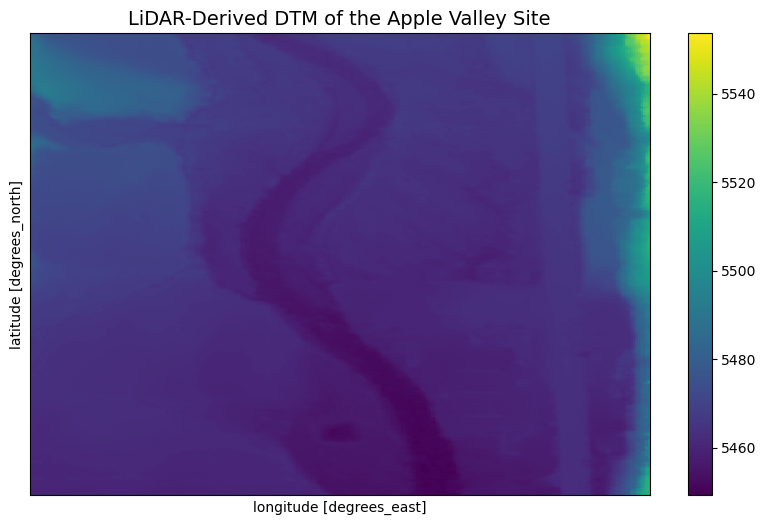

In [35]:
# Plot the Lidar DTM - single site
plot_model(model = av_lidar_dtm, 
           title = 'LiDAR-Derived DTM of the Apple Valley Site', 
           coarsen = True)

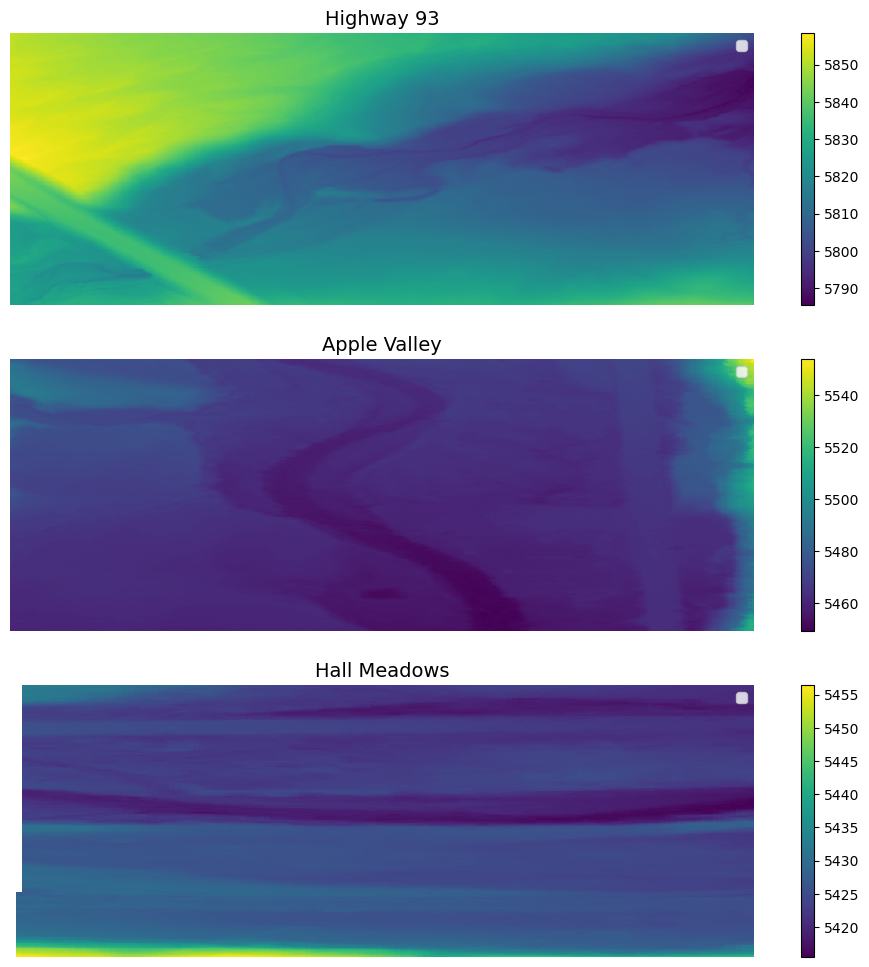

In [39]:
# Define plot space with x subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# List of fire names to pass to function
site_name = ('Highway 93', 'Apple Valley', 'Hall Meadows')

# List of dtms to pass to function
lidar_dtm_list = (hwy93_lidar_dtm, av_lidar_dtm, hm_lidar_dtm)

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=lidar_dtm_list[i],
        title=site_name[i],
        coarsen=(False, False, False),
        ax=axe)

# Run REMMaker tool using LiDAR DTM as input

In [ ]:
# Input the DEM file path and desired output directory
override_cache = True
# Path to clipped lidar dtm
clipped_lidar_dtm_path = os.path.join('LiDAR_DTM_Highway93.tif')
lidar_dir = 'lidar_hw93'
lidar_rem_path = os.path.join(lidar_dir, 'LiDAR_DTM_Highway93_REM.tif')

# Run the REMMaker if the path to the REM does not already exist
if (not os.path.exists(lidar_rem_path)) or override_cache:
    rem_maker = REMMaker(dem=clipped_lidar_dtm_path, out_dir=lidar_dir, interp_pts=1000, k=100)

    # clear OSM cache
    clear_osm_cache()

    # create an REM
    rem_maker.make_rem()

    # create an REM visualization with the given colormap
    rem_maker.make_rem_viz(cmap='mako_r')

else:
    print('The REM already exists. Not running REMMaker')

In [ ]:
# Open the REM you just generated
lidar_rem = rxr.open_rasterio(lidar_rem_path, masked=True)
# Plot the REM 
plot_model(model = lidar_rem, 
           title = 'REM derived from LiDAR', 
           coarsen = True)
# Note - I increased value of k in the REMMAker and it got rid of the streaking!!
# "param k: number of nearest neighbors to use for IDW interpolation. If None, an appropriate value is estimated.
   #           The estimation routine uses k between 5-100 points (0.5-10% of the river length) depending on the
    #          sinuosity of the river of interest. Greater values of k are used for more sinuous rivers.""

In [ ]:
# Call function to plot histogram of REM
plot_hist(model=lidar_rem, 
          title="Histogram of the REM Data, Highway 93 Site", 
          color="cyan")